In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.preprocessing import LabelEncoder
# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
# from tabulate import tabulate
# from sklearn.utils.class_weight import compute_sample_weight
import seaborn as sns
# import joblib
# import os
from pandas.tseries.offsets import DateOffset
from markov_helpers import *
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv(r'C:\Users\samvi\Documents\Coding Projects\Embedded Work\Data_Used\Training_Data.csv')

C:\Users\samvi\AppData\Local\Temp\ipykernel_59932\2712093529.py:1: DtypeWarning: Columns (16,23,30,33,36,37,38,39,40,41,42,43,44,50,53,55,58,59,60,65) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\samvi\Documents\Coding Projects\Embedded Work\Data_Used\Training_Data.csv')


In [3]:
df.head(3)

,Loan Number,Start,Stop,Age,State,Acquisition Date,Note Date,Maturity Date at Acquisition,Loan Acquisition UPB,Amortization Type,...,Loan Age,Green Bond Indicator,Social Bond Indicator,Proportion Through Loan,Percentage Paid,Paid per Age,LTV_over_DSCR,NoteRate_over_DSCR,Current_LTV_Approx,LTV_times_DSCR
0,1673867584,0,1,0,Current,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,...,64.0,N,NaN,0.016529,0.000720,0.000000,64.0,6.1192,79.942377,100.0
1,1673867584,1,2,1,Current,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,...,64.0,N,NaN,0.024793,0.001445,0.001445,64.0,6.1192,79.884387,100.0
2,1673867584,2,3,2,Current,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,...,64.0,N,NaN,0.033058,0.002175,0.001087,64.0,6.1192,79.826027,100.0


In [4]:
df = df.drop('Proportion Through Loan', axis=1)
#df = df.drop('Original Term (Months)', axis=1)
#df = df.drop('Months Into Loan', axis=1)
#df = df.rename(columns={'Proportion Through Loan': 'old prop'})

In [5]:
col_names = df.columns

In [6]:
prediction_period_length = 6
Macro_buffer = 3
df = add_next_state(df, prediction_period_length)

In [7]:
df['Reporting Period Date'] = pd.to_datetime(df['Reporting Period Date'], errors='coerce')
df['Date_Pair_To_Macro'] = df['Reporting Period Date'] + pd.DateOffset(months=prediction_period_length-Macro_buffer)

In [8]:
# Making proportion through loan column
df['Note Date'] = pd.to_datetime(df['Note Date'], errors='coerce')
df['Maturity Date at Acquisition'] = pd.to_datetime(df['Maturity Date at Acquisition'], errors='coerce')
df['Reporting Period Date'] = pd.to_datetime(df['Reporting Period Date'], errors='coerce')
df['Date_Pair_To_Macro'] = pd.to_datetime(df['Date_Pair_To_Macro'], errors='coerce')



def month_diff(start, end):
    return (end.dt.year - start.dt.year) * 12 + (end.dt.month - start.dt.month)


df['Original Term (Months)'] = month_diff(df['Note Date'], df['Maturity Date at Acquisition'])

df['Months Into Loan'] = month_diff(df['Note Date'], df['Date_Pair_To_Macro'])
df['Proportion Through Loan'] = df['Months Into Loan'] / df['Original Term (Months)']
df['Proportion Through Loan'] = df['Proportion Through Loan'].clip(lower=0, upper=1)

In [9]:
pd.set_option('display.max_columns', None)
df.head(3)

,Loan Number,Start,Stop,Age,State,Acquisition Date,Note Date,Maturity Date at Acquisition,Loan Acquisition UPB,Amortization Type,Interest Type,Loan Product Type,Original UPB,Amortization Term,Original Interest Rate,Lien Position,Transaction ID,Issue Date,Loan Acquisition LTV,Underwritten DSCR,Underwritten DSCR Type,Original Term,Original I/O Term,I/O End Date,Loan Ever 60+ Days Delinquent,Loss Sharing Type,Modified Loss Sharing Percentage,Number of Properties at Acquisition,Property Acquisition Total Unit Count,Specific Property Type,Year Built,Property City,Property State,Property Zip Code,Metropolitan Statistical Area,Physical Occupancy %,Liquidation/Prepayment Code,Liquidation/Prepayment Date,Foreclosure Date,Credit Event Date,Foreclosure Value,Lifetime Net Credit Loss Amount,Sale Price,Default Amount,Credit Event Type,Reporting Period Date,Loan Active Property Count,Note Rate,Maturity Date - Current,UPB - Current,Delinquency UPB,Loan Payment Status,SDQ Indicator,Most Recent Modification Date,Modification Indicator,Defeasance Date,Prepayment Provision,Prepayment Provision End Date,Affordable Housing Type,MCIRT Deal ID,MCAS Deal ID,DUS Prepayment Outcomes,DUS Prepayment Segments,Loan Age,Green Bond Indicator,Social Bond Indicator,Percentage Paid,Paid per Age,LTV_over_DSCR,NoteRate_over_DSCR,Current_LTV_Approx,LTV_times_DSCR,Next State,Date_Pair_To_Macro,Original Term (Months),Months Into Loan,Proportion Through Loan
0,1673867584,0,1,0,Current,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,Fixed,DUS,14736000.0,360.0,7.649,First,382113.0,2000-01-01,80.0,1.25,Lender UW DSCR,120.0,NaN,NaN,N,NaN,NaN,1.0,408.0,Multifamily,1985,ARLINGTON,TX,76017,"DALLAS-FORT WORTH-ARLINGTON, TX METROPOLITAN S...",92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-01-01,1.0,7.65,2009-12-01,14725385.83,NaN,Current,N,NaN,N,NaN,"YM(114), O*(6)",NaN,NaN,NaN,NaN,Paid Prior to Yield Maintenance End Date,Standard,64.0,N,NaN,0.000720,0.000000,64.0,6.1192,79.942377,100.0,Current,2000-04-01,121,5,0.041322
1,1673867584,1,2,1,Current,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,Fixed,DUS,14736000.0,360.0,7.649,First,382113.0,2000-01-01,80.0,1.25,Lender UW DSCR,120.0,NaN,NaN,N,NaN,NaN,1.0,408.0,Multifamily,1985,ARLINGTON,TX,76017,"DALLAS-FORT WORTH-ARLINGTON, TX METROPOLITAN S...",92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-02-01,1.0,7.65,2009-12-01,14714704.00,NaN,Current,N,NaN,N,NaN,"YM(114), O*(6)",NaN,NaN,NaN,NaN,Paid Prior to Yield Maintenance End Date,Standard,64.0,N,NaN,0.001445,0.001445,64.0,6.1192,79.884387,100.0,Current,2000-05-01,121,6,0.049587
2,1673867584,2,3,2,Current,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,Fixed,DUS,14736000.0,360.0,7.649,First,382113.0,2000-01-01,80.0,1.25,Lender UW DSCR,120.0,NaN,NaN,N,NaN,NaN,1.0,408.0,Multifamily,1985,ARLINGTON,TX,76017,"DALLAS-FORT WORTH-ARLINGTON, TX METROPOLITAN S...",92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-03-01,1.0,7.65,2009-12-01,14703954.09,NaN,Current,N,NaN,N,NaN,"YM(114), O*(6)",NaN,NaN,NaN,NaN,Paid Prior to Yield Maintenance End Date,Standard,64.0,N,NaN,0.002175,0.001087,64.0,6.1192,79.826027,100.0,Current,2000-06-01,121,7,0.057851


In [10]:
# le_state = LabelEncoder()
# df['State Encoded'] = le_state.fit_transform(df['State'])
# df['Next State Encoded'] = le_state.transform(df['Next State'])

#Hopefully the same every time now

le_state = LabelEncoder()
all_states = sorted(set(df['State'].dropna()).union(set(df['Next State'].dropna())))
le_state.fit(all_states)

df['State Encoded'] = le_state.transform(df['State'])
df['Next State Encoded'] = le_state.transform(df['Next State'])

encoding_map = {label: idx for idx, label in enumerate(le_state.classes_)}
print(encoding_map)

{np.str_('Current'): 0, np.str_('Default'): 1, np.str_('Foreclosure'): 2, np.str_('Fully Paid, Matured'): 3, np.str_('Fully Paid, Prepaid'): 4}


In [11]:
pairs_1 = {'Fixed': 0, 'ARM': 1}
df = encode_col(df, 'Interest Type', pairs_1, 'Interest Type Encoded')

pairs_2 = {'Amortizing Balloon': 0, 'Interest Only/Amortizing/Balloon': 1, 'Interest Only/Balloon': 2, 'Fully Amortizing': 3, 'Interest Only/Fully Amortizing': 4}
df = encode_col(df, 'Amortization Type', pairs_2, 'Amortization Type Encoded')

In [12]:
# PAIR WITH HISTORIC MACRO DATA

macros = pd.read_csv(r'C:\Users\samvi\Documents\Coding Projects\Embedded Work\Data_Used\Historic_Econ_monthly.csv')

df = join_on_date(df, macros, on_col1='Date_Pair_To_Macro', on_col2='Date', how='left', exact=False)

In [13]:
# PAIR WITH MSA LEVEL DATA
MSAs = pd.read_csv(r'C:\Users\samvi\Documents\Coding Projects\Embedded Work\Data_Used\MSA Master Sheet.csv')
df = clean_MSA_naming(df, 'Metropolitan Statistical Area')
df = pd.merge(df, MSAs, left_on='MSA_clean', right_on='MSA Name', how='left')

In [14]:
df = df.sort_values(by=["Loan Number", "Reporting Period Date"])

In [15]:
pd.set_option('display.max_columns', None)
df.head(2)

,Loan Number,Start,Stop,Age,State,Acquisition Date,Note Date,Maturity Date at Acquisition,Loan Acquisition UPB,Amortization Type,Interest Type,Loan Product Type,Original UPB,Amortization Term,Original Interest Rate,Lien Position,Transaction ID,Issue Date,Loan Acquisition LTV,Underwritten DSCR,Underwritten DSCR Type,Original Term,Original I/O Term,I/O End Date,Loan Ever 60+ Days Delinquent,Loss Sharing Type,Modified Loss Sharing Percentage,Number of Properties at Acquisition,Property Acquisition Total Unit Count,Specific Property Type,Year Built,Property City,Property State,Property Zip Code,Metropolitan Statistical Area,Physical Occupancy %,Liquidation/Prepayment Code,Liquidation/Prepayment Date,Foreclosure Date,Credit Event Date,Foreclosure Value,Lifetime Net Credit Loss Amount,Sale Price,Default Amount,Credit Event Type,Reporting Period Date,Loan Active Property Count,Note Rate,Maturity Date - Current,UPB - Current,Delinquency UPB,Loan Payment Status,SDQ Indicator,Most Recent Modification Date,Modification Indicator,Defeasance Date,Prepayment Provision,Prepayment Provision End Date,Affordable Housing Type,MCIRT Deal ID,MCAS Deal ID,DUS Prepayment Outcomes,DUS Prepayment Segments,Loan Age,Green Bond Indicator,Social Bond Indicator,Percentage Paid,Paid per Age,LTV_over_DSCR,NoteRate_over_DSCR,Current_LTV_Approx,LTV_times_DSCR,Next State,Date_Pair_To_Macro,Original Term (Months),Months Into Loan,Proportion Through Loan,State Encoded,Next State Encoded,Interest Type Encoded,Amortization Type Encoded,Real GDP growth,Nominal GDP growth,Real disposable income growth,Nominal disposable income growth,Unemployment rate,CPI inflation rate,3-month Treasury yield,5-year Treasury yield,10-year Treasury yield,BBB corporate yield,Mortgage rate,Prime rate,Dow Jones Total Stock Market Index,House Price Index,Commercial Real Estate Price Index,Market Volatility Index (VIX),Euro Area Real GDP Growth,Euro Area Inflation,Euro Area Bilateral Dollar Exchange Rate (USD/Euro),Developing Asia Real GDP Growth,Developing Asia Inflation,"Developing Asia Bilateral Dollar Exchange Rate (F/USD, Index)",Japan Real GDP Growth,Japan Inflation,Japan Bilateral Dollar Exchange Rate (Yen/USD),UK Real GDP Growth,UK Inflation,UK Bilateral Dollar Exchange Rate (USD/Pound),MSA_clean,MSA Code,MSA Name,FIPS State Code,HPI Volatility,Most Recent HPI,Population,Unemployment Rate
0,1673867584,0,1,0,Current,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,Fixed,DUS,14736000.0,360.0,7.649,First,382113.0,2000-01-01,80.0,1.25,Lender UW DSCR,120.0,NaN,NaN,N,NaN,NaN,1.0,408.0,Multifamily,1985,ARLINGTON,TX,76017,"DALLAS-FORT WORTH-ARLINGTON, TX METROPOLITAN S...",92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-01-01,1.0,7.65,2009-12-01,14725385.83,NaN,Current,N,NaN,N,NaN,"YM(114), O*(6)",NaN,NaN,NaN,NaN,Paid Prior to Yield Maintenance End Date,Standard,64.0,N,NaN,0.000720,0.000000,64.0,6.1192,79.942377,100.0,Current,2000-04-01,121,5,0.041322,0,0,0,0,7.500000,10.200000,4.8,6.800000,3.900000,3.100000,5.700000,6.400000,6.200000,8.600000,8.4,9.300000,10470.000000,106.000000,132.0,29.000000,4.7,2.000000,0.932000,6.000000,2.0,103.000000,1.5,-0.700000,106.000000,3.800000,0.500000,1.542,"Dallas Fort Worth Arlington, TX",19100.0,"Dallas Fort Worth Arlington, TX",48.0,4.0,295.7,8344032.0,3.9
150,1673867584,1,2,1,Current,2000-01-01,1999-11-01,2009-12-01,"$14,725,385.83",Amortizing Balloon,Fixed,DUS,14736000.0,360.0,7.649,First,382113.0,2000-01-01,80.0,1.25,Lender UW DSCR,120.0,NaN,NaN,N,NaN,NaN,1.0,408.0,Multifamily,1985,ARLINGTON,TX,76017,"DALLAS-FORT WORTH-ARLINGTON, TX METROPOLITAN S...",92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-02-01,1.0,7.65,2009-12-01,14714704.00,NaN,Current,N,NaN,N,NaN,"YM(114), O*(6)",NaN,NaN,NaN,NaN,Paid Prior to Yield Maintenance End Date,Standard,64.0,N,NaN,0.001445,0.001445,64.0,6.1192,79.884387,100.0,Current,2000-05-01,121,6,0.049587,0,0,0,0,5.133333,7.733333,5.0,7.233333,3.933333,3.166667,5.833333,6.233333,6.066667,8.766667,8.3,9.366667,1

In [16]:
feature_cols = ['State Encoded', 'Age', 'Original UPB', 'UPB - Current', 'Note Rate', 'Underwritten DSCR', 
                'Original Term', 'Loan Acquisition LTV', 'Proportion Through Loan', 'Amortization Type Encoded', 
                'Interest Type Encoded', 'Percentage Paid', 'Paid per Age', 
                'LTV_over_DSCR', 'NoteRate_over_DSCR', 'Current_LTV_Approx', 'LTV_times_DSCR', 
                'Real GDP growth', 'Nominal GDP growth', 'Real disposable income growth', 'Nominal disposable income growth', 'Unemployment rate', 'CPI inflation rate', '3-month Treasury yield', '5-year Treasury yield', '10-year Treasury yield', 'BBB corporate yield', 'Mortgage rate', 'Prime rate', 'Dow Jones Total Stock Market Index', 'House Price Index', 'Commercial Real Estate Price Index', 'Market Volatility Index (VIX)', 'Euro Area Real GDP Growth', 'Euro Area Inflation', 'Euro Area Bilateral Dollar Exchange Rate  (USD/Euro)', 'Developing Asia Real GDP Growth', 'Developing Asia Inflation', 'Developing Asia Bilateral Dollar Exchange Rate (F/USD, Index)', 'Japan Real GDP Growth', 'Japan Inflation', 'Japan Bilateral Dollar Exchange Rate (Yen/USD)', 'UK Real GDP Growth', 'UK Inflation', 'UK Bilateral Dollar Exchange Rate (USD/Pound)', 
                'FIPS State Code', 'HPI Volatility', 'Most Recent HPI', 'Population', 'Unemployment Rate']

#feature_cols = ['State Encoded', 'Proportion Through Loan', 'Original UPB', 'Note Rate', 'Amortization Type Encoded', 'Loan Acquisition LTV']

X = df[feature_cols]
y = df['Next State Encoded']

In [17]:
#df = downsample(df, 1000)

In [18]:
# Possible data leakage via loan information across time 

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.2,
#     random_state=42,
#     stratify=y  # ensures class balance in both sets
# )

# Step 1: Get unique loan numbers
unique_loans = df['Loan Number'].unique()

# Step 2: Train-test split on loan IDs (not rows!)
from sklearn.model_selection import train_test_split

train_loans, test_loans = train_test_split(
    unique_loans,
    test_size=0.2,
    random_state=42
)

# Step 3: Filter rows based on those loans
train_mask = df['Loan Number'].isin(train_loans)
test_mask = df['Loan Number'].isin(test_loans)

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

c:\Users\samvi\Documents\Coding Projects\Embedded Work\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:28:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Overall Accuracy: 74.85%


c:\Users\samvi\Documents\Coding Projects\Embedded Work\State Model\markov_helpers.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")


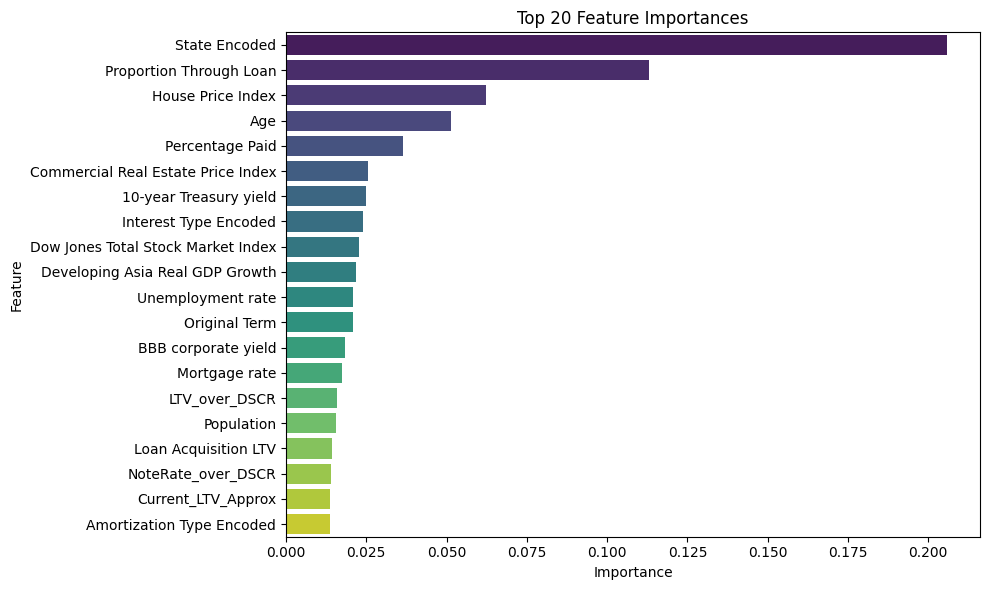

In [19]:
model = train_model(X, y, X_train, y_train, X_test, y_test, le_state)
evaluate_model(model, X_test, y_test, le_state)

In [20]:
save_model(model, 'testing4')

Model size: 3.86 MB


In [19]:
model = joblib.load(r"C:\Users\samvi\Documents\Coding Projects\Embedded Work\State Model\testing4.pkl")

In [20]:
test = pd.DataFrame(columns=col_names)

new_row = {
    'Age': 48, 
    'Proportion Through Loan': float(48/60),
    'Note Date': pd.to_datetime("Jul 19, 2021", format="%b %d, %Y"),
    'Maturity Date at Acquisition': pd.to_datetime("July 19, 2026", format="%B %d, %Y"),
    'State': 'Current',
    'Original UPB': 66500000.0,
    'Amortization Term': 60.0,
    'Original Interest Rate': 2.38,
    'Loan Acquisition LTV': 74.5,
    'Original Term': 60,
    'Property Acquisition Total Unit Count': 275,
    'Specific Property Type': 'Multifamily',
    'Year Built': 2020,
    'Property City': 'Peoria',
    'Property State': 'AZ',
    'Property Zip Code': 85345,
    'Metropolitan Statistical Area': 'Phoenix Mesa Chandler, AZ', #Closest
    'Physical Occupancy %': 85,
    'Reporting Period Date': pd.to_datetime("July 2025", format="%B %Y"),
    'Note Rate': 2.38,
    'Current_LTV_Approx': 126.5,
    'Interest Type': 'Fixed',
    'MSA_clean': 'Phoenix Mesa Chandler, AZ'
}

test = pd.concat([test, pd.DataFrame([new_row])], ignore_index=True)

C:\Users\samvi\AppData\Local\Temp\ipykernel_52572\2971154271.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test = pd.concat([test, pd.DataFrame([new_row])], ignore_index=True)


In [21]:
test.head()

,Loan Number,Start,Stop,Age,State,Acquisition Date,Note Date,Maturity Date at Acquisition,Loan Acquisition UPB,Amortization Type,Interest Type,Loan Product Type,Original UPB,Amortization Term,Original Interest Rate,Lien Position,Transaction ID,Issue Date,Loan Acquisition LTV,Underwritten DSCR,Underwritten DSCR Type,Original Term,Original I/O Term,I/O End Date,Loan Ever 60+ Days Delinquent,Loss Sharing Type,Modified Loss Sharing Percentage,Number of Properties at Acquisition,Property Acquisition Total Unit Count,Specific Property Type,Year Built,Property City,Property State,Property Zip Code,Metropolitan Statistical Area,Physical Occupancy %,Liquidation/Prepayment Code,Liquidation/Prepayment Date,Foreclosure Date,Credit Event Date,Foreclosure Value,Lifetime Net Credit Loss Amount,Sale Price,Default Amount,Credit Event Type,Reporting Period Date,Loan Active Property Count,Note Rate,Maturity Date - Current,UPB - Current,Delinquency UPB,Loan Payment Status,SDQ Indicator,Most Recent Modification Date,Modification Indicator,Defeasance Date,Prepayment Provision,Prepayment Provision End Date,Affordable Housing Type,MCIRT Deal ID,MCAS Deal ID,DUS Prepayment Outcomes,DUS Prepayment Segments,Loan Age,Green Bond Indicator,Social Bond Indicator,Percentage Paid,Paid per Age,LTV_over_DSCR,NoteRate_over_DSCR,Current_LTV_Approx,LTV_times_DSCR,Proportion Through Loan,MSA_clean
0,NaN,NaN,NaN,48,Current,NaN,2021-07-19,2026-07-19,NaN,NaN,Fixed,NaN,66500000.0,60.0,2.38,NaN,NaN,NaN,74.5,NaN,NaN,60,NaN,NaN,NaN,NaN,NaN,NaN,275,Multifamily,2020,Peoria,AZ,85345,"Phoenix Mesa Chandler, AZ",85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-01,NaN,2.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.5,NaN,0.8,"Phoenix Mesa Chandler, AZ"


In [22]:
test['State Encoded'] = le_state.fit_transform(test['State'])
pairs_1 = {'Fixed': 0, 'ARM': 1}
test = encode_col(test, 'Interest Type', pairs_1, 'Interest Type Encoded')

prediction_period_length = 6

test['Reporting Period Date'] = pd.to_datetime(test['Reporting Period Date'], errors='coerce')
test['Date_Pair_To_Macro'] = test['Reporting Period Date'] + pd.DateOffset(months=prediction_period_length)

macros = pd.read_csv(r'C:\Users\samvi\Documents\Coding Projects\Embedded Work\Data_Used\Fannie_monthly, Baseline Domestic.csv')

test = join_on_date(test, macros, on_col1='Date_Pair_To_Macro', on_col2='Date', how='left', exact=False)

MSAs = pd.read_csv(r'C:\Users\samvi\Documents\Coding Projects\Embedded Work\Data_Used\MSA Master Sheet.csv')
test = pd.merge(test, MSAs, left_on='MSA_clean', right_on='MSA Name', how='left')

test = test.sort_values(by=["Loan Number", "Reporting Period Date"])

pd.set_option('display.max_columns', None)
test.head(2)

,Loan Number,Start,Stop,Age,State,Acquisition Date,Note Date,Maturity Date at Acquisition,Loan Acquisition UPB,Amortization Type,Interest Type,Loan Product Type,Original UPB,Amortization Term,Original Interest Rate,Lien Position,Transaction ID,Issue Date,Loan Acquisition LTV,Underwritten DSCR,Underwritten DSCR Type,Original Term,Original I/O Term,I/O End Date,Loan Ever 60+ Days Delinquent,Loss Sharing Type,Modified Loss Sharing Percentage,Number of Properties at Acquisition,Property Acquisition Total Unit Count,Specific Property Type,Year Built,Property City,Property State,Property Zip Code,Metropolitan Statistical Area,Physical Occupancy %,Liquidation/Prepayment Code,Liquidation/Prepayment Date,Foreclosure Date,Credit Event Date,Foreclosure Value,Lifetime Net Credit Loss Amount,Sale Price,Default Amount,Credit Event Type,Reporting Period Date,Loan Active Property Count,Note Rate,Maturity Date - Current,UPB - Current,Delinquency UPB,Loan Payment Status,SDQ Indicator,Most Recent Modification Date,Modification Indicator,Defeasance Date,Prepayment Provision,Prepayment Provision End Date,Affordable Housing Type,MCIRT Deal ID,MCAS Deal ID,DUS Prepayment Outcomes,DUS Prepayment Segments,Loan Age,Green Bond Indicator,Social Bond Indicator,Percentage Paid,Paid per Age,LTV_over_DSCR,NoteRate_over_DSCR,Current_LTV_Approx,LTV_times_DSCR,Proportion Through Loan,MSA_clean,State Encoded,Interest Type Encoded,Date_Pair_To_Macro,Real GDP growth,Nominal GDP growth,Real disposable income growth,Nominal disposable income growth,Unemployment rate,CPI inflation rate,3-month Treasury yield,5-year Treasury yield,10-year Treasury yield,BBB corporate yield,Mortgage rate,Prime rate,Dow Jones Total Stock Market Index,House Price Index,Commercial Real Estate Price Index,Market Volatility Index (VIX),Euro Area Real GDP Growth,Euro Area Inflation,Euro Area Bilateral Dollar Exchange Rate (USD/Euro),Developing Asia Real GDP Growth,Developing Asia Inflation,"Developing Asia Bilateral Dollar Exchange Rate (F/USD, Index)",Japan Real GDP Growth,Japan Inflation,Japan Bilateral Dollar Exchange Rate (Yen/USD),UK Real GDP Growth,UK Inflation,UK Bilateral Dollar Exchange Rate (USD/Pound),MSA Code,MSA Name,FIPS State Code,HPI Volatility,Most Recent HPI,Population,Unemployment Rate
0,NaN,NaN,NaN,48,Current,NaN,2021-07-19,2026-07-19,NaN,NaN,Fixed,NaN,66500000.0,60.0,2.38,NaN,NaN,NaN,74.5,NaN,NaN,60,NaN,NaN,NaN,NaN,NaN,NaN,275,Multifamily,2020,Peoria,AZ,85345,"Phoenix Mesa Chandler, AZ",85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-01,NaN,2.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.5,NaN,0.8,"Phoenix Mesa Chandler, AZ",0,0,2026-01-01,2.0,4.7,2.6,5.2,4.3,2.8,3.7,4.0,4.2,5.8,5.9,6.9,58399.3,330.0,317.0,27.0,1.2,1.8,1.067,4.2,1.8,108.7,0.8,1.7,145.7,1.5,2.4,1.285,38060,"Phoenix Mesa Chandler, AZ",4,6.159406,512.17,5186958,3.2


In [23]:
# Convert all datetime columns to numeric (e.g., timestamp)
for col in test.select_dtypes(include='datetime').columns:
    test[col] = test[col].astype('int64')  # Or .view('int64') for older pandas

# Encode all remaining object columns
for col in test.select_dtypes(include='object').columns:
    test[col] = test[col].astype('category').cat.codes

In [24]:
test = test.reindex(columns=feature_cols)

In [25]:
prob_df, y_pred_encoded = predict_all(model, test)

In [21]:
prob_df, y_pred_encoded = predict_all(model, X_test)

In [26]:
prob_df

,0,1,2,3,4
0,0.742166,0.11795,0.000522,0.079048,0.060313


In [22]:
encoding_map = {label: idx for idx, label in enumerate(le_state.classes_)}
print(encoding_map)

{np.str_('Current'): 0, np.str_('Default'): 1, np.str_('Foreclosure'): 2, np.str_('Fully Paid, Matured'): 3, np.str_('Fully Paid, Prepaid'): 4}


In [23]:
pred_series = pd.Series(y_pred_encoded, index=X_test.index, name='Predicted_State_Encoded')
loans_with_preds = X_test.copy()
loans_with_preds = loans_with_preds.join(pred_series)
loans_with_preds['Predicted_State'] = le_state.inverse_transform(loans_with_preds['Predicted_State_Encoded'])
loans_with_preds['Previous_State'] = le_state.inverse_transform(loans_with_preds['State Encoded'])

In [24]:
actual_series = pd.Series(y_test.values, index=y_test.index, name='Actual_State_Encoded')
loans_with_preds = loans_with_preds.join(actual_series)
loans_with_preds['Actual_State'] = le_state.inverse_transform(loans_with_preds['Actual_State_Encoded'])

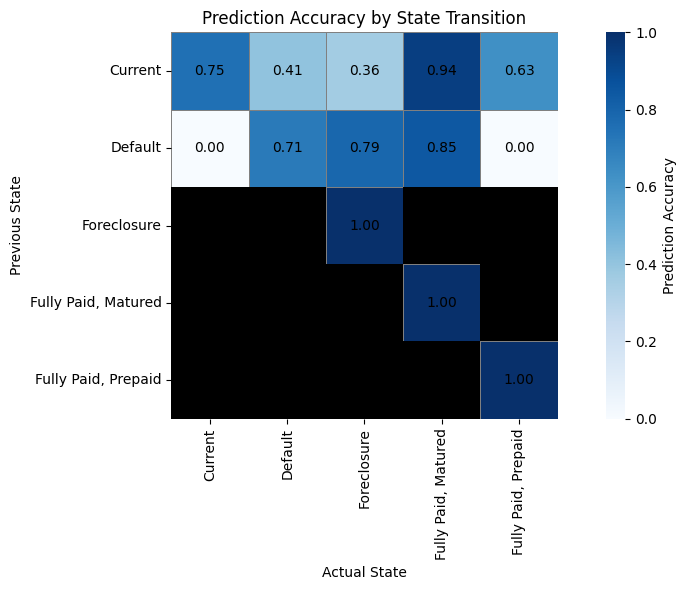

In [25]:
# Step 1: Mark correct predictions
loans_with_preds["Correct"] = loans_with_preds["Predicted_State"] == loans_with_preds["Actual_State"]

# Step 2: All possible transitions
prev_states = sorted(loans_with_preds["Previous_State"].unique())
actual_states = sorted(loans_with_preds["Actual_State"].unique())
full_index = pd.MultiIndex.from_product([prev_states, actual_states], names=["Previous_State", "Actual_State"])

# Step 3: Accuracy and counts
accuracy = (
    loans_with_preds
    .groupby(["Previous_State", "Actual_State"])["Correct"]
    .mean()
    .reindex(full_index)
    .unstack()
)

counts = (
    loans_with_preds
    .groupby(["Previous_State", "Actual_State"])["Correct"]
    .count()
    .reindex(full_index)
    .unstack()
)

# Step 4: Replace NaN with 0 for heatmap (so color scale works), but remember where they were
heatmap_data = accuracy.fillna(0)
missing_mask = counts.isna()

# Step 5: Plot normally
fig, ax = plt.subplots(figsize=(10, 6))
cmap = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(
    heatmap_data,
    annot=False,
    fmt=".2f",
    cmap=cmap,
    cbar_kws={'label': 'Prediction Accuracy'},
    linewidths=0.5,
    linecolor='gray',
    square=True,
    vmin=0,
    vmax=1,
    ax=ax
)

# Step 6: Add annotations only for valid transitions
for i in range(accuracy.shape[0]):
    for j in range(accuracy.shape[1]):
        if not missing_mask.iloc[i, j]:
            val = accuracy.iloc[i, j]
            ax.text(j + 0.5, i + 0.5, f"{val:.2f}", ha='center', va='center', color='black')

# Step 7: Draw black boxes for missing transitions
for i in range(accuracy.shape[0]):
    for j in range(accuracy.shape[1]):
        if missing_mask.iloc[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color='black', lw=0))

# Final touches
ax.set_title("Prediction Accuracy by State Transition")
ax.set_xlabel("Actual State")
ax.set_ylabel("Previous State")
plt.tight_layout()
plt.show()

Overall Accuracy: 74.85%


c:\Users\samvi\Documents\Coding Projects\Embedded Work\State Model\markov_helpers.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")


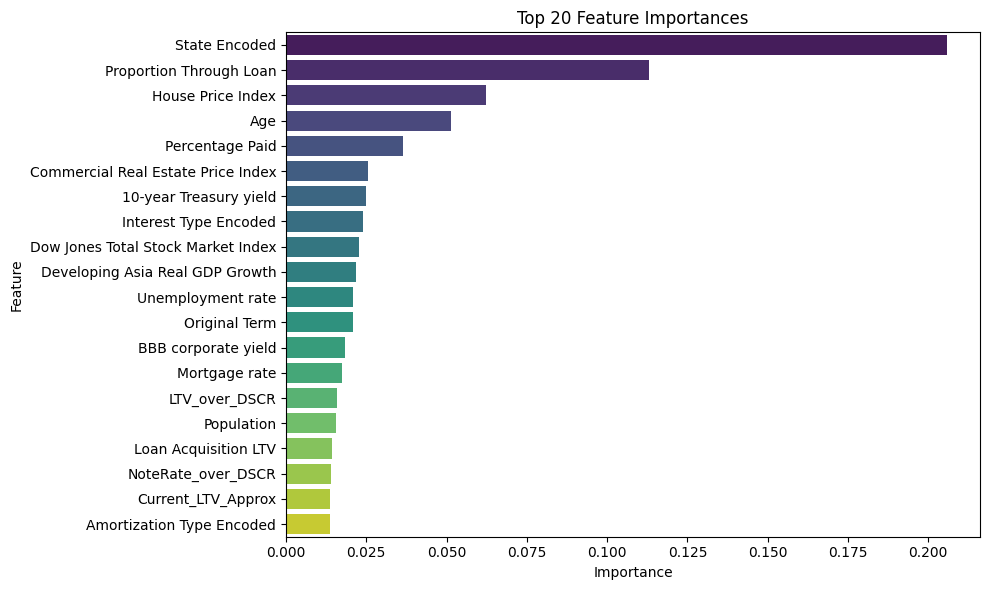

In [27]:
evaluate_model(model, X_test, y_test, le_state)

In [19]:
latest_date = df['Reporting Period Date'].max()
print(latest_date)

2024-12-01 00:00:00


In [18]:
df = loans_with_preds
# First, create a boolean column to mark correct predictions
df['Correct'] = df['Predicted_State'] == df['Actual_State']

# Then group by actual state and compute percent correct
accuracy_by_state = df.groupby('Actual_State')['Correct'].mean().sort_values(ascending=False)

# Optional: turn into percent format
accuracy_by_state = (accuracy_by_state * 100).round(2)

In [19]:
accuracy_by_state

Actual_State
Foreclosure            100.00
Fully Paid, Prepaid    100.00
Fully Paid, Matured    100.00
Current                 73.68
Default                 73.41
Name: Correct, dtype: float64